In [1]:
# file data read and make the train/validation data sets
import os
import csv
#import cv2
import numpy as np
#import sklearn
#from sklearn.utils import shuffle
#from sklearn.model_selection import train_test_split

samples = []

with open('./training_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        rndsel = np.random.randint(3)
        
        img_name_center = line[0].split('/')[-1]
        ang_val_center = float(line[3])     
        sample = img_name_center, ang_val_center
        samples.append(sample)
        
        if (ang_val_center != 0.0):
            samples.append(sample)
        
        if (rndsel == 0):
            img_name_left = line[1].split('/')[-1]
            ang_val_left = ang_val_center + 0.25
            sample_l = img_name_left, ang_val_left
            samples.append(sample_l)
        
        if (rndsel == 1):
            img_name_right = line[2].split('/')[-1]
            ang_val_right = ang_val_center - 0.25
            sample_r = img_name_right, ang_val_right
            samples.append(sample_r)
            
                    
print(len(samples))

29808


In [2]:
from sklearn.utils import shuffle
samples = shuffle(samples)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

Random Number =  472
D:\Workspace\UCND\projects\project3\CarND-Behavioral-Cloning-P3-master\CarND-Behavioral-Cloning-P3-master\training_data\IMG\right_2017_07_18_16_17_29_785.jpg -0.20096726


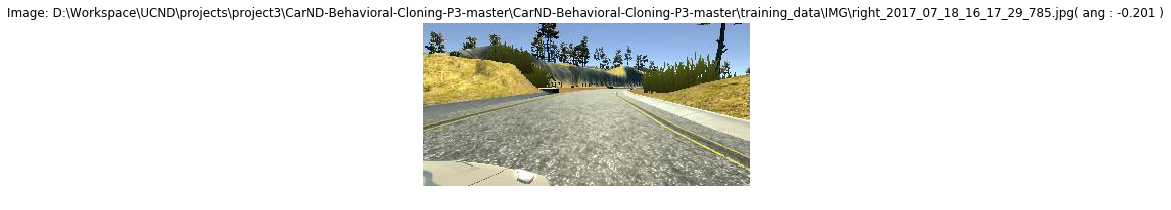

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
rnd = np.random.randint(len(train_samples))
print ('Random Number = ', rnd)
print(train_samples[rnd][0], train_samples[rnd][1])
name = train_samples[rnd][0]
image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
angle = train_samples[rnd][1]
plt.figure(figsize=(12,3))
#plt.subplot(1,3,1)
plt.imshow(image)
plt.title('Image: '+name + '( ang : ' + str(np.round(angle,3)) + ' )')
plt.axis('off')
plt.show()

In [4]:
# Generator
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle

def data_shift(image, angle):
    shift_max = 55
    angle_max = 0.14 #angle per pixel = 0.0025
    rows, cols, ch = image.shape
    rnd = np.random.randint(-shift_max, shift_max + 1)
    angle = angle + ( rnd / shift_max ) * angle_max
    if abs(angle > 1.):
        angle = -1. if (angle < 0) else 1
    mat = np.float32([[1, 0, rnd], [0, 1, 0]])
    image = cv2.warpAffine(image, mat, (cols, rows))
    return image, angle

def data_flip(image, angle):
    return cv2.flip(image,1), angle*-1.0

def data_brightness(image, angle):
    img_tmp = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    img_tmp[:,:,2] = img_tmp[:,:,2] * np.random.uniform(0.1, 1.2)
    image = cv2.cvtColor(img_tmp, cv2.COLOR_HSV2RGB)
    return image, angle 

def random_augmented_data(image, angle):
    rand = np.random.randint(7)
    if rand == 0 or rand == 4 or rand ==5 or rand ==6:      #horizontal flip
        image, angle = data_flip(image, angle)
    elif rand == 1: #brightness
        image, angle = data_brightness(image, angle)
    elif rand == 2: #flip & brightness
        tmp_img, tmp_angle = data_flip(image, angle)
        image, angle = data_brightness(tmp_img, tmp_angle)
    elif rand ==3:  #shift
        image, angle = data_shift(image, angle)
        
    return image, angle

#def random_select_data(batch_sample, correction):
#    rand = np.random.randint(3)        
#   angle = batch_sample[1]
#   return image, angle        

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+int(batch_size/2)]
            images = []
            angles = []
            for batch_sample in batch_samples:
                image = cv2.imread(batch_sample[0])
                angle = batch_sample[1]
                images.append(image)
                angles.append(angle)
            
            batch_samples = samples[offset+int(batch_size/2):offset+int(batch_size/2):offset+int(batch_size)]
            for batch_sample in batch_samples:
                image = cv2.imread(batch_sample[0])
                angle = batch_sample[1]
                
                #tmp_img, tmp_ang = random_select_data(batch_sample, correction)
                rnd_img, rnd_ang = random_augmented_data(image, angle)
                images.append(rnd_img)
                angles.append(rnd_ang)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train)
            
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [ ]:
# The model is based on NVIDIA's "End to End Learning for Self-Driving Cars" paper
# Source:  https://arxiv.org/pdf/1604.07316.pdf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation, Dropout
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
keep_prob = 0.5
model = Sequential()
# First Normalize layer, credit to comma ai model
#model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(66, 200, 3)))
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160, 320, 3))) # Normalizing & mean centering the data
model.add(Cropping2D(cropping=((60,30),(0,0)), input_shape=(160, 320, 3)))
# Color space conversion layer, credit to Vivek's model
model.add(Convolution2D(3, 1, 1, border_mode='same', name='color_conv'))
# Classic five convolutional, Nvidia model and additional maxpooling layers
model.add(Convolution2D(24, 5, 5, border_mode='valid', activation='relu', subsample=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu', subsample=(2, 2)))
model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='relu', subsample=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu', subsample=(1, 1)))
model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu', subsample=(1, 1)))
model.add(Flatten())
# Next, five fully connected layers
model.add(Dense(1164, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(keep_prob))
model.add(Dense(50, activation='relu'))
model.add(Dropout(keep_prob))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

Using TensorFlow backend.


In [ ]:
from keras.optimizers import Adam
model.compile(loss='mse', optimizer=Adam(lr=1e-4))
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples),
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples),
                    nb_epoch=5, verbose=1)

model.save('model.h5')

Epoch 1/5
23846/23846 [==============================] - 907s - loss: 0.0168 - val_loss: 0.0108
Epoch 2/5
10358/23846 [============>.................] - ETA: 440s - loss: 0.0130

In [ ]:
# Visualize Model Training History

#from keras.models import Model
import matplotlib.pyplot as plt

#history_object = model.fit_generator(train_generator, samples_per_epoch =
#    len(train_samples), validation_data = 
#    validation_generator,
#    nb_val_samples = len(validation_samples), 
#    nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()